In [1]:
import importlib
import GNN_module.scripts as scripts #only used for on the fly reloads
import torch
import copy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from torch_geometric.nn.models import GAT, GCN
from sklearn.model_selection import ParameterGrid
import numpy as np

from GNN_module.scripts import *
from GNN_module.metrics import *
import torch.nn.functional as F
from carbontracker.tracker import CarbonTracker


In [35]:
#Run this to reload the scripts without restarting the kernel
importlib.reload(scripts)
from GNN_module.scripts import *
from GNN_module.metrics import *

# IMPORTANT: write requirements file and readme after work is done

# Datasets

In [2]:
dataset_cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
dataset_citeseer = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
dataset_pubmed = Planetoid(root='data/Planetoid', name='Pubmed', transform=NormalizeFeatures())

In [34]:
dataset = dataset_cora
data = dataset[0]  # Get the first graph object.
dataset_statistics(dataset)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Model initialising

In [36]:
gat = GAT(in_channels=dataset.num_features, hidden_channels=32, num_layers=2, out_channels=dataset.num_classes, heads=8, dropout=0.6, act=F.elu)
optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)

gatv2 = GAT(v2 = True, in_channels=dataset.num_features, hidden_channels=12, num_layers=2, out_channels=dataset.num_classes, heads=4, dropout=0.8, act=F.elu)
optimizer_gatv2 = torch.optim.Adam(gatv2.parameters(), lr=0.005, weight_decay=5e-4)
#gcn = GCN(in_channels=dataset.num_features, hidden_channels=8, out_channels=dataset.num_classes, num_layers=2, dropout=0.6)
#optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

criterion = torch.nn.CrossEntropyLoss()

In [37]:
num_params_gat = count_trainable_parameters(gat)
num_params_gatv2 = count_trainable_parameters(gatv2)
#num_params_gcn = count_trainable_parameters(gcn)

print(f'Number of trainable parameters in GAT: {num_params_gat}')
print(f'Number of trainable parameters in GATv2: {num_params_gatv2}')
#print(f'Number of trainable parameters in GCN: {num_params_gcn}')

Number of trainable parameters in GAT: 47863
Number of trainable parameters in GATv2: 35203


# Training

In [38]:
num_epochs = 500

In [39]:
loss_list_gat = train_model(num_epochs, gat, data, optimizer_gat, criterion)
loss_list_gatv2 = train_model(num_epochs, gatv2, data, optimizer_gatv2, criterion)
#loss_list_gcn = train_model(num_epochs, gcn, data, optimizer_gcn, criterion)

Training model...

Training model...0.44484314322471624



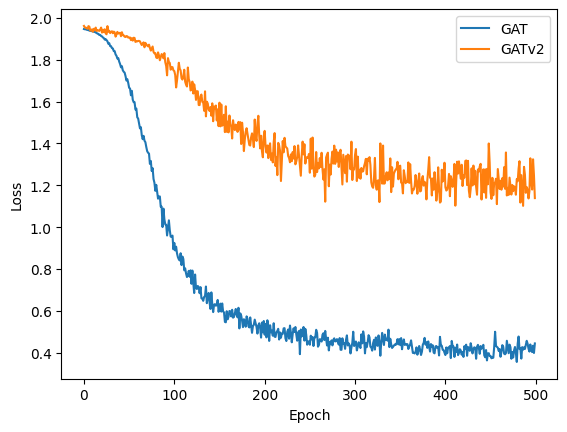

In [40]:
plt.plot(loss_list_gat[:500], label='GAT')
plt.plot(loss_list_gatv2[:500], label='GATv2')
#plt.plot(loss_list_gcn[:500], label='GCN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('Training Loss over Epochs')
plt.show()

In [41]:
test_model(data.test_mask, gat, data), test_model(data.test_mask, gatv2, data)#, test_model(data.test_mask, gcn, data)

(0.797, 0.812)

# Research ideas





## Robustness of GATs to Adversarial Attacks
### Research Question: 
How robust are Graph Attention Networks to adversarial attacks compared to other GNN architectures?
### Hypothesis:
 GATs, due to their ability to focus on important nodes via attention, are more robust against adversarial attacks than non-attention-based GNNs like Graph Convolutional Networks (GCNs).
### Novelty:
You can simulate simple adversarial attacks (e.g., perturbing node features or edges) and compare the robustness of GATs vs. GCNs or other GNN architectures.



## Transfer Learning with Graph Attention Networks
### Research Question:
Can GATs trained on one type of graph (e.g., a citation network) be effectively transferred to another type (e.g., a social network) using transfer learning?
### Hypothesis:
GATs are more effective for transfer learning between graphs of similar structures (e.g., citation networks to co-authorship networks) compared to graphs with significantly different structures (e.g., citation to biological networks).
### Novelty:
Explore transfer learning in GNNs, specifically GATs, which is less explored. You can train on one graph type, fine-tune on another, and measure performance gains.


# Hyperparameter sweep

In [5]:

with open('sweeps/sweep_results_gat_cora.pkl', 'rb') as f:
    sweep_gat = pickle.load(f)
with open('sweeps/sweep_results_gatv2_cora.pkl', 'rb') as f:
    sweep_gatv2 = pickle.load(f)

In [6]:

gat_best = get_best(sweep_gat)
gatv2_best = get_best(sweep_gatv2)

In [7]:
gat_best['test_accuracy'], gatv2_best['test_accuracy']

(0.816, 0.824)

In [9]:
gat_best['hyperparameters'], gatv2_best['hyperparameters']

({'dropout': 0.6, 'heads': 8, 'hidden_channels': 4, 'num_layers': 2},
 {'dropout': 0.8, 'heads': 4, 'hidden_channels': 3, 'num_layers': 2})

# Robustness

We can test robustness to disruptions in the data in a number of ways:

- Adding feature noise (Gaussian noise to each feature or noise acroos entire dataset)
- Adding non existing edges
- Removing edges

## Feature noise

Doing n tests corresponds to repeating the experiment n times
Here we test feature noise robustness. Both for global noise, where we add noise to the feature tensor of the entire graph and local noise where we add noise to the individual feature tensors. Each tests adds noise up to a certain scale. The standard range is from 0 to 0.25 with a step size of 0.01. The noise added is sampled from a normal distribution with zero mean and unit variance.
Doing both n tests, and ploting standard deviation and doing normal tests. If each test is only done once, then the repeats parameter should be set to False

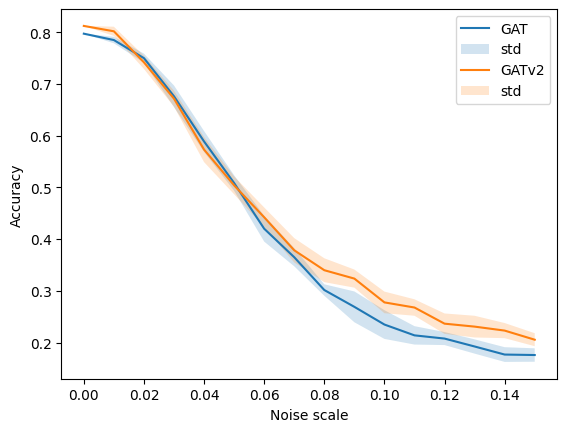

In [44]:
# TODO normalize for accuacy degrading

n = 10
#scale, test_gcn = do_n_tests(test_feature_noise_robustness, gcn, data, n=n, global_noise = False)
scale, tests_gat = do_n_tests(test_feature_noise_robustness, gat, data, n=n, global_noise=False)
scale, tests_gatv2 = do_n_tests(test_feature_noise_robustness, gatv2, data, n=n, global_noise=False)

tests10 = np.array([tests_gat, tests_gatv2])
plot_n_tests(tests10, scale, titels=['GAT', 'GATv2'])

In [45]:
print('GAT')
robustness_report(tests_gat)
print('GATv2')
robustness_report(tests_gatv2)

GAT
Performance variance: 0.0003077049999999999
CV: 0.05352136146800639
AUC: 6.1759
GATv2
Performance variance: 0.00031266312499999996
CV: 0.04937850132103614
AUC: 6.5207


## Adding edges

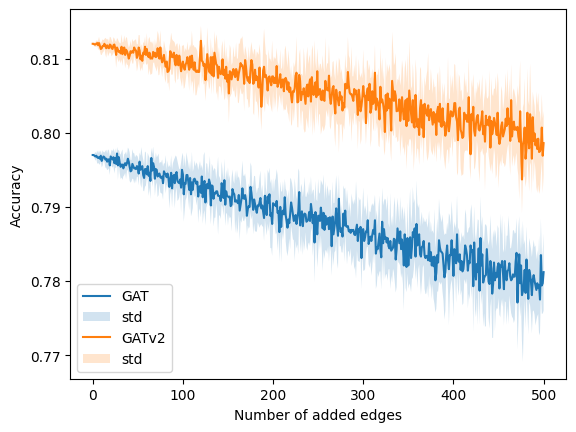

In [46]:
n = 10
num_added_edges, acc_gat = do_n_tests(test_edge_noise_robustness, gat, data, n=n)
_, acc_gatv2 = do_n_tests(test_edge_noise_robustness, gatv2, data, n=n)
results = np.array([acc_gat, acc_gatv2])
plot_n_tests(results, num_added_edges, titels=['GAT', 'GATv2'], xlabel='Number of added edges')

In [47]:
print('GAT')
robustness_report(acc_gat)
print('GATv2')
robustness_report(acc_gatv2)

GAT
Performance variance: 1.4682534930139746e-05
CV: 0.004491784208598812
AUC: 394.07719999999995
GATv2
Performance variance: 1.4022934131736487e-05
CV: 0.004269419519745841
AUC: 402.8224


## Removing edges

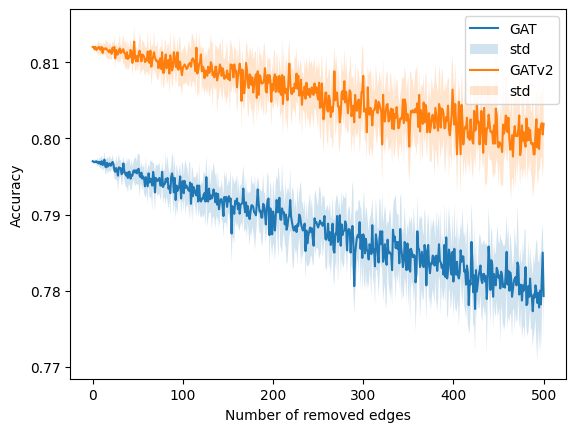

In [48]:
num_removed_edges, acc_gat_remove = do_n_tests(test_edge_noise_robustness, gat, data, n=10)
_, acc_gatv2_remove = do_n_tests(test_edge_noise_robustness, gatv2, data, n=10)
results = np.array([acc_gat_remove, acc_gatv2_remove])
plot_n_tests(results, num_removed_edges, titels=['GAT', 'GATv2'], xlabel='Number of removed edges')

In [49]:
print('GAT')
robustness_report(acc_gat_remove)
print('GATv2')
robustness_report(acc_gatv2_remove)

GAT
Performance variance: 1.4699940119760503e-05
CV: 0.004481540844880991
AUC: 394.10755000000006
GATv2
Performance variance: 1.3820499001995969e-05
CV: 0.004269526582849564
AUC: 402.87235000000004


# Robustness metrics

Metrics we could try:
- Acuracy degradation
- RMSE (Prediction stability)
- Area under the curve

And for the variance based approaches
- Performance variance
- Coefficient of variation
- Linear degradation slope

These have been added to the GNN_module. Remove them later

In [165]:
def robustness_report(tests):
    #Performance variance, CV, AUC. All the mean versions
    perf_var = mean_performance_variance(tests)
    cv = mean_CV(tests)
    auc = mean_AUC(tests)
    print(f'Performance variance: {perf_var}')
    print(f'CV: {cv}')
    print(f'AUC: {auc}')

## Acuracy degradation

In [140]:
def acc_degr(s0, si):
    return (s0 - si) / s0

def normalize_acc_degr(acc_list):
    s0 = acc_list[0]
    return np.array([acc_degr(s0, si) for si in acc_list])





## Performance variance

In [158]:
def performance_variance(test_list):
    '''Given a list of test results, calculate the variance of the accuracy'''
    np.array(test_list)
    return np.var(test_list)

def mean_performance_variance(tests):
    '''Given a list of test results, calculate the mean variance of the accuracy'''
    return np.mean([performance_variance(test) for test in tests.T])

def std_performance_variance(tests):
    '''Given a list of test results, calculate the standard deviation of the variance of the accuracy'''
    return np.std([performance_variance(test) for test in tests.T])

## Coefficient of variation

In [153]:
def CV(test_list):
    mean = np.mean(test_list)
    std = np.std(test_list)
    return std / mean

def mean_CV(tests):
    return np.mean([CV(test) for test in tests.T])

def std_CV(tests):
    return np.std([CV(test) for test in tests.T])

## Area under the curve

In [154]:
def AUC(perf_list):
    return np.trapz(perf_list)

def mean_AUC(tests):
    return np.mean([AUC(test) for test in tests])

def std_AUC(tests):
    return np.std([AUC(test) for test in tests])